# Nye Fowler Solver (Python) v1.0

This Jupyter Notebook solves the Nye Fowler equations described by section 1 of the associated Latex document (to be added).

This version of the notebook solves the base equations described by section 1.


## Code:
First, we import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from IPython.display import clear_output


Next, we get our constants set up. These are mostly adjustable.

In [2]:
rho_w = 1000 # kg/m^3 (water density)
rho_i = 900 #kg/m^3 (ice density)
g = 10 # m/s^2 (gravitational acceleration)
L = 3.3*10**5 # J/kg
K0 = 10**-24 # Pa^-3 s^-2
phi_s = 0.01 # surface slope
psi_0 = rho_w*g*phi_s 
n_prime = 0.1 # m^-1/3 s (hydraulic roughness)
f = 6.6*n_prime**2 
s_to_y = 60*60*24*365.25 

# Scales
s0 = 10*10**3 # m
Q0 = 1500 # m^3/s
m0 = Q0*psi_0/L 
S0 = (f*rho_w*g*Q0**2/psi_0)**(3/8)
N0 = (K0*rho_i*S0*L/(psi_0*Q0))**(-1/3)
t0 = rho_i*S0*L/(psi_0*Q0)
M0 = Q0/s0
h0 = 90

# Model Params
eps = s0*m0/(Q0*rho_i)
r = rho_i/rho_w
delta = N0/(s0*psi_0)

# Inputs
Q_in = 10/Q0
hL_pl1 = 1
beta_r = 0.9

lda = 3.2
psi = 1
M = 0

# Details for storage of variables, user specified
grid_space = 100 
time_space = 10000
del_t = 0.05 

# Storage arrays
x = np.linspace(0,1,grid_space)
h = np.zeros(time_space)
S = np.zeros((time_space,grid_space))
Q = np.zeros((time_space,grid_space))
N = np.zeros((time_space,grid_space))

# Initial conditions
S[0,:] = 5*np.ones(grid_space)/S0
h[0] = 1/3
psi_var = psi*(1-3*np.exp(-20*x))

# Boundary conditions
NL = beta_r*(1-h[0])
Nt = rho_i*g*1/N0


Now, we set up the functions that the solver uses. This first one defines the coupled differential equations for Q and N

In [3]:
def Nye_NQ(x,y):
    S_i_var = np.interp(x,np.linspace(0,1,grid_space),S_i)
    S83 = S_i_var**(8/3)
    Q = y[1]
    N = y[0]
    psi_var_interp = np.interp(x,np.linspace(0,1,grid_space),psi_var)
    return np.vstack(((Q*np.abs(Q)/S83 - psi_var_interp)/delta, 
                      eps*(r-1)*np.abs(Q)**3/S83 + eps*S_i_var*N**3 + M))

This function defines the boundary conditions

In [4]:
def bc_N(ya,yb):
    return np.array([ya[0]-NL, yb[0]-Nt])

This code snippet solves the system of differential equations. It takes a while to run, and an output appears below the box (though it looks erratic, it paints a sense of if the code is running properly and how long it has been running for

In [5]:
%%time
# initial guess
y = np.zeros((2, x.size))
y[0,:]= np.sin(x*np.pi)
y[1,:]= 0.001 + M*x# solve initial step
S_i = S[0,:]
sol = solve_bvp(Nye_NQ, bc_N,x,y,verbose=2)
N[0,:]=np.interp(x,sol.x,sol.y[0])
Q[0,:]=np.interp(x,sol.x,sol.y[1])

S[1,:] = S_i + del_t*(np.abs(Q[0,:])**3/S_i**(8/3) - S_i*N[0,:]**3)
h[1] = h[0] + del_t*lda*(Q_in-Q[0,0])/hL_pl1;
NL = beta_r*(1-h[1])
# Now we loop
for i in range(1,time_space-1):
    print(i)
    clear_output(wait=True)
    x = np.linspace(0,1,grid_space)
    y = np.zeros((2, x.size))
    y[0,:]= N[i-1,:]
    y[1,:]= Q[i-1,:]
    S_i = S[i,:]
    sol = solve_bvp(Nye_NQ, bc_N,x,y,tol=0.00000001,bc_tol=0.00000001,verbose=2,max_nodes=10000)
    if sol.status == 2:
        break
    N[i,:]=np.interp(x,sol.x,sol.y[0])
    Q[i,:]=np.interp(x,sol.x,sol.y[1])
    S[i+1,:] = S_i + del_t*(np.abs(Q[i,:])**3/S_i**(8/3) - S_i*N[i,:]**3)
    h[i+1] = h[i] + del_t*lda*(Q_in-Q[i,0])/hL_pl1
    if (h[i+1]<=0) or (S[i+1,:].any()<=0):
        break
    NL = beta_r*(1-h[i])

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.18e-02       0.00e+00          100            81       
       2          1.91e-03       0.00e+00          181            163      
       3          8.48e-05       0.00e+00          344            245      
       4          3.36e-06       0.00e+00          589            268      
       5          1.27e-07       0.00e+00          857            261      
       6          1.62e-08       0.00e+00         1118            95       
       7          9.97e-09       0.00e+00         1213             0       
Solved in 7 iterations, number of nodes 1213. 
Maximum relative residual: 9.97e-09 
Maximum boundary residual: 0.00e+00
CPU times: user 6min 15s, sys: 42.2 s, total: 6min 57s
Wall time: 6min 16s


Now, the output from above is converted into values with units for our plots. At some point it could be wise to export these values into a csv to save the data

In [6]:
s_km = s0*np.linspace(0,1,grid_space)/1000
time_years = t0*del_t*np.arange(time_space)/s_to_y
h_meters = h0*h
Q_m3ps = Q0*Q
S_m2 = S0*S
N_Pa = N0*N

Now, the plots for lake depth, channel flow rate (at entrance and exit), and channel surface area (at entrance and exit) are made.

Text(0.5, 0, 'time, t (years)')

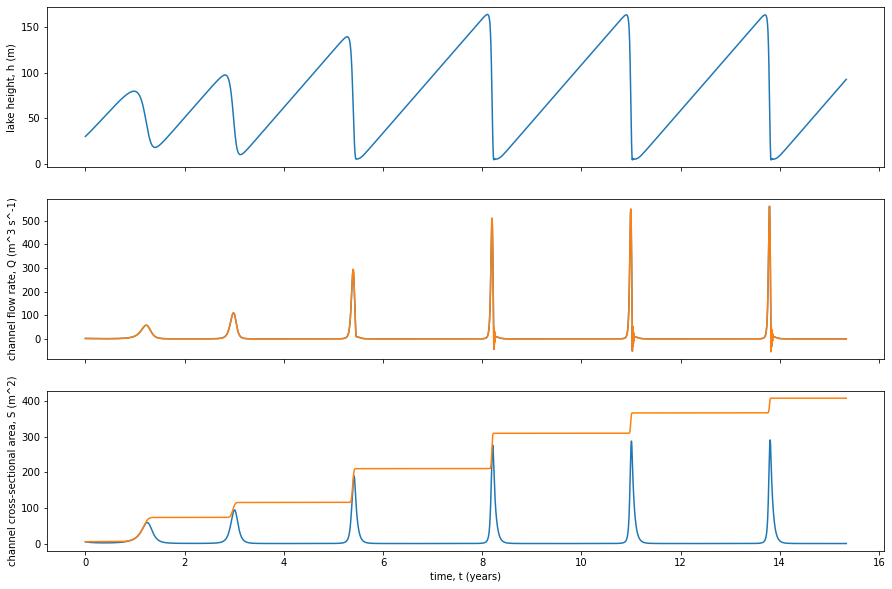

In [7]:
fig, ax = plt.subplots(3,figsize=[15,10],sharex=True)
#plt.xlim([0,7])
ax[0].plot(time_years,h_meters)
ax[0].set_ylabel('lake height, h (m)')

ax[1].plot(time_years,Q_m3ps[:,0])
ax[1].plot(time_years,Q_m3ps[:,-1])
ax[1].set_ylabel('channel flow rate, Q (m^3 s^-1)')

ax[2].plot(time_years,S_m2[:,0])
ax[2].plot(time_years,S_m2[:,-1])
ax[2].set_ylabel('channel cross-sectional area, S (m^2)')
ax[2].set_xlabel('time, t (years)')


The following plots are colormaps of the effective pressure, channel flow rate, cross sectional area, and glacier basal velocity. 

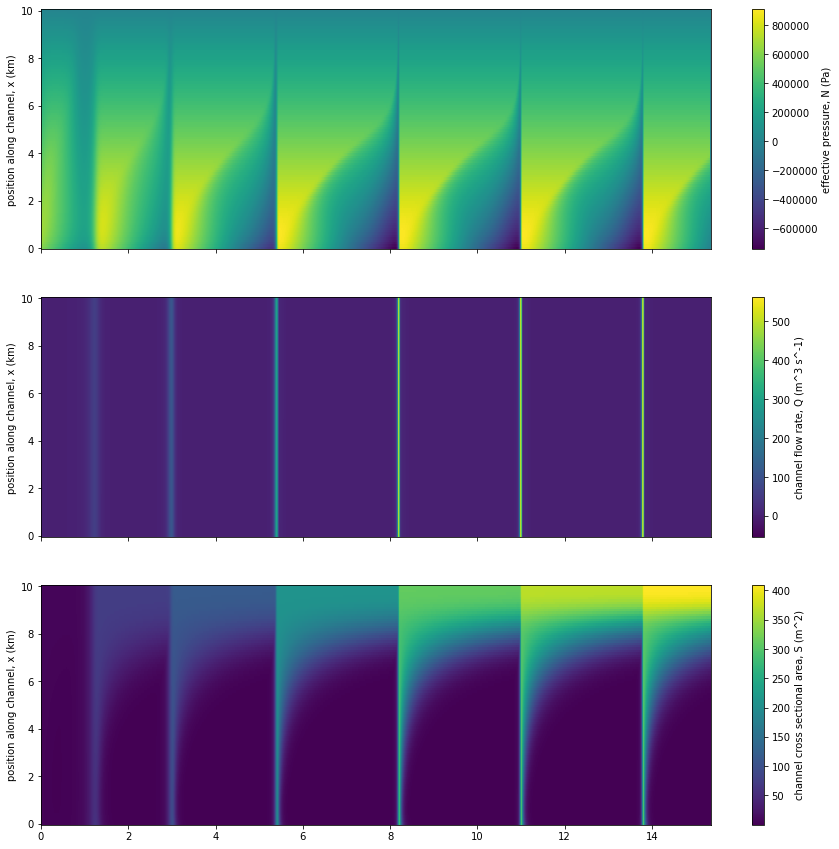

In [8]:
fig, ax = plt.subplots(3,figsize=[15,15],sharex=True)
#plt.xlim([0,7])
p0 = ax[0].pcolormesh(time_years,s_km,N_Pa.transpose(),shading='auto')
ax[0].set_ylabel('position along channel, x (km)')
cbar0 = fig.colorbar(p0,ax=ax[0])
cbar0.set_label('effective pressure, N (Pa)')

p1 = ax[1].pcolormesh(time_years,s_km,Q_m3ps.transpose(),shading='auto')
ax[1].set_ylabel('position along channel, x (km)')
cbar1 = fig.colorbar(p1,ax=ax[1])
cbar1.set_label('channel flow rate, Q (m^3 s^-1)')

p2 = ax[2].pcolormesh(time_years,s_km,S_m2.transpose(),shading='auto')
ax[2].set_ylabel('position along channel, x (km)')
cbar2 = fig.colorbar(p2,ax=ax[2])
cbar2.set_label('channel cross sectional area, S (m^2)')


The remaining cells are just spaces for debugging.

In [9]:
np.max(h_meters)

163.55719485537375